In [1]:
# QVM Engine v3j - Base Strategy (Equal Weight)

# QVM Engine v3j - Base Strategy Analysis

**Objective:** Base strategy with equal weight allocation, no factors, no regime detection.
This serves as the baseline for comparing component contributions.

**File:** 01_base_strategy.py

In [2]:
# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
import yaml

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
from sqlalchemy import create_engine, text

# Import shared components
from components.base_engine import BaseEngine

# IMPORTS AND SETUP

In [3]:
# Environment Setup
warnings.filterwarnings('ignore')

# Add Project Root to Python Path
try:
    current_path = Path.cwd()
    while not (current_path / 'production').is_dir():
        if current_path.parent == current_path:
            raise FileNotFoundError("Could not find the 'production' directory.")
        current_path = current_path.parent
    
    project_root = current_path
    
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    from production.database.connection import get_database_manager
    from production.database.mappings.financial_mapping_manager import FinancialMappingManager
    print(f"✅ Successfully imported production modules.")
    print(f"   - Project Root set to: {project_root}")

except (ImportError, FileNotFoundError) as e:
    print(f"❌ ERROR: Could not import production modules. Please check your directory structure.")
    print(f"   - Final Path Searched: {project_root}")
    print(f"   - Error: {e}")
    raise

✅ Successfully imported production modules.
   - Project Root set to: /Users/raymond/Documents/Projects/factor-investing-public


# CONFIGURATION AND DATABASE SETUP

In [4]:
QVM_CONFIG = {
    # Backtest Parameters
    "strategy_name": "QVM_Engine_v3j_Base",
    "backtest_start_date": "2016-01-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "M", # Monthly
    "transaction_cost_bps": 30, # Flat 30bps
    
    # Universe Construction
    "universe": {
        "lookback_days": 63,
        "top_n_stocks": 200,  # Top 200 stocks by ADTV
        "max_position_size": 0.05,
        "max_sector_exposure": 0.30,
        "target_portfolio_size": 20,
    },
    
    # Factor Configuration (not used in base strategy)
    "factors": {
        "roaa_weight": 0.0,  # No factor weighting
        "pe_weight": 0.0,    # No factor weighting
        "momentum_weight": 0.0,  # No factor weighting
        "momentum_horizons": [21, 63, 126, 252], # 1M, 3M, 6M, 12M
        "skip_months": 1,
        "fundamental_lag_days": 45,  # 45-day lag for announcement delay
    },
    
    # Regime Configuration (not used in base strategy)
    "regime": {
        "lookback_period": 90,          # 90 days lookback period
        "volatility_threshold": 0.0140, # 1.40% (75th percentile from real data)
        "return_threshold": 0.0012,     # 0.12% (75th percentile from real data)
        "low_return_threshold": 0.0002  # 0.02% (corrected 25th percentile)
    }
}

print("\n⚙️  QVM Engine v3j Base Strategy Configuration Loaded:")
print(f"   - Strategy: {QVM_CONFIG['strategy_name']}")
print(f"   - Period: {QVM_CONFIG['backtest_start_date']} to {QVM_CONFIG['backtest_end_date']}")
print(f"   - Universe: Top {QVM_CONFIG['universe']['top_n_stocks']} stocks by ADTV")
print(f"   - Allocation: Equal weight (no factors, no regime)")
print(f"   - Performance: Pre-computed data + Vectorized operations")


⚙️  QVM Engine v3j Base Strategy Configuration Loaded:
   - Strategy: QVM_Engine_v3j_Base
   - Period: 2016-01-01 to 2025-07-28
   - Universe: Top 200 stocks by ADTV
   - Allocation: Equal weight (no factors, no regime)
   - Performance: Pre-computed data + Vectorized operations


# DATABASE CONNECTION

In [5]:
def create_db_connection():
    """Establishes a SQLAlchemy database engine connection."""
    try:
        db_manager = get_database_manager()
        engine = db_manager.get_engine()
        
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f"\n✅ Database connection established successfully.")
        return engine

    except Exception as e:
        print(f"❌ FAILED to connect to the database.")
        print(f"   - Error: {e}")
        return None

# Create the engine for this session
engine = create_db_connection()

if engine is None:
    raise ConnectionError("Database connection failed. Halting execution.")

2025-08-04 00:22:43,365 - production.database.connection - INFO - Database configuration loaded from /Users/raymond/Documents/Projects/factor-investing-public/config/database.yml
2025-08-04 00:22:43,367 - production.database.connection - INFO - DatabaseManager initialized for environment: production
2025-08-04 00:22:43,461 - production.database.connection - INFO - SQLAlchemy engine created successfully



✅ Database connection established successfully.


# BASE STRATEGY ENGINE

In [6]:
class QVMEngineV3jBase:
    """
    QVM Engine v3j Base Strategy - Equal Weight Allocation.
    No factors, no regime detection - serves as baseline for component analysis.
    """
    def __init__(self, config: dict, price_data: pd.DataFrame, fundamental_data: pd.DataFrame,
                 returns_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine, precomputed_data: dict):
        
        self.config = config
        self.engine = db_engine
        self.precomputed_data = precomputed_data
        
        # Slice data to the exact backtest window
        start = pd.Timestamp(config['backtest_start_date'])
        end = pd.Timestamp(config['backtest_end_date'])
        
        self.price_data_raw = price_data[price_data['date'].between(start, end)].copy()
        self.fundamental_data_raw = fundamental_data[fundamental_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        
        # Initialize base engine
        self.base_engine = BaseEngine(config, db_engine)
        
        # Pre-process precomputed data for faster access
        self._setup_precomputed_data()
        
        print("✅ QVMEngineV3jBase initialized.")
        print(f"   - Strategy: {config['strategy_name']}")
        print(f"   - Period: {self.daily_returns_matrix.index.min().date()} to {self.daily_returns_matrix.index.max().date()}")
        print(f"   - Allocation: Equal weight baseline")

    def _setup_precomputed_data(self):
        """Setup precomputed data for fast access during rebalancing."""
        # Create fast lookup structures
        self.universe_lookup = self.precomputed_data['universe'].set_index(['trading_date', 'ticker']).index
        self.fundamental_lookup = self.precomputed_data['fundamentals'].set_index(['date', 'ticker'])
        self.momentum_lookup = self.precomputed_data['momentum'].set_index(['trading_date', 'ticker'])
        
        print("   ✅ Pre-computed data indexed for fast access")

    def run_backtest(self) -> (pd.Series, pd.DataFrame):
        """Executes the base strategy backtesting pipeline."""
        print("\n🚀 Starting QVM Engine v3j base strategy backtest execution...")
        
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings, diagnostics = self._run_base_backtesting_loop(rebalance_dates)
        net_returns = self._calculate_net_returns(daily_holdings)
        
        print("✅ QVM Engine v3j base strategy backtest execution complete.")
        return net_returns, diagnostics

    def _generate_rebalance_dates(self) -> list:
        """Generates monthly rebalance dates based on actual trading days."""
        all_trading_dates = self.daily_returns_matrix.index
        rebal_dates_calendar = pd.date_range(
            start=self.config['backtest_start_date'],
            end=self.config['backtest_end_date'],
            freq=self.config['rebalance_frequency']
        )
        actual_rebal_dates = [all_trading_dates[all_trading_dates.searchsorted(d, side='left')-1] for d in rebal_dates_calendar if d >= all_trading_dates.min()]
        print(f"   - Generated {len(actual_rebal_dates)} monthly rebalance dates.")
        return sorted(list(set(actual_rebal_dates)))

    def _run_base_backtesting_loop(self, rebalance_dates: list) -> (pd.DataFrame, pd.DataFrame):
        """Base backtesting loop with equal weight allocation."""
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        diagnostics_log = []
        
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing rebalance {i+1}/{len(rebalance_dates)}: {rebal_date.date()}...", end="")
            
            # Get universe (no filtering)
            universe = self._get_universe_from_precomputed(rebal_date)
            if len(universe) < 5:
                print(" ⚠️ Universe too small. Skipping.")
                continue
            
            # Equal weight allocation (no regime detection)
            regime_allocation = 1.0  # Always fully invested
            
            # No factor analysis - just use universe
            qualified_stocks = universe[:self.config['universe']['target_portfolio_size']]
            
            if len(qualified_stocks) == 0:
                print(" ⚠️ No qualified stocks. Skipping.")
                continue
            
            # Construct equal weight portfolio
            target_portfolio = self._construct_equal_weight_portfolio(qualified_stocks, regime_allocation)
            if target_portfolio.empty:
                print(" ⚠️ Portfolio empty. Skipping.")
                continue
            
            # Apply holdings
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = self.daily_returns_matrix.index[(self.daily_returns_matrix.index >= start_period) & (self.daily_returns_matrix.index <= end_period)]
            
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            
            # Calculate turnover
            if i > 0:
                try:
                    prev_holdings_idx = self.daily_returns_matrix.index.get_loc(rebal_date) - 1
                except KeyError:
                    prev_dates = self.daily_returns_matrix.index[self.daily_returns_matrix.index < rebal_date]
                    if len(prev_dates) > 0:
                        prev_holdings_idx = self.daily_returns_matrix.index.get_loc(prev_dates[-1])
                    else:
                        prev_holdings_idx = -1
                
                prev_holdings = daily_holdings.iloc[prev_holdings_idx] if prev_holdings_idx >= 0 else pd.Series(dtype='float64')
            else:
                prev_holdings = pd.Series(dtype='float64')

            turnover = (target_portfolio - prev_holdings.reindex(target_portfolio.index).fillna(0)).abs().sum() / 2.0
            
            diagnostics_log.append({
                'date': rebal_date,
                'universe_size': len(universe),
                'portfolio_size': len(target_portfolio),
                'regime': 'Equal',  # No regime detection
                'regime_allocation': regime_allocation,
                'turnover': turnover
            })
            print(f" ✅ Universe: {len(universe)}, Portfolio: {len(target_portfolio)}, Regime: Equal, Turnover: {turnover:.2%}")

        if diagnostics_log:
            return daily_holdings, pd.DataFrame(diagnostics_log).set_index('date')
        else:
            return daily_holdings, pd.DataFrame()

    def _get_universe_from_precomputed(self, analysis_date: pd.Timestamp) -> list:
        """Get universe from pre-computed data (no database query)."""
        # Filter precomputed universe data for the analysis date
        universe_data = self.precomputed_data['universe']
        date_universe = universe_data[universe_data['trading_date'] == analysis_date]
        return date_universe['ticker'].tolist()

    def _construct_equal_weight_portfolio(self, qualified_stocks: list, regime_allocation: float) -> pd.Series:
        """Construct equal weight portfolio."""
        if not qualified_stocks:
            return pd.Series(dtype='float64')
        
        # Equal weight portfolio
        portfolio = pd.Series(regime_allocation / len(qualified_stocks), index=qualified_stocks)
        
        return portfolio

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        """Calculate net returns with transaction costs."""
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        # Calculate turnover and costs
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        net_returns = (gross_returns - costs).rename(self.config['strategy_name'])
        
        print("\n💸 Net returns calculated.")
        print(f"   - Total Gross Return: {(1 + gross_returns).prod() - 1:.2%}")
        print(f"   - Total Net Return: {(1 + net_returns).prod() - 1:.2%}")
        print(f"   - Total Cost Drag: {(gross_returns.sum() - net_returns.sum()):.2%}")
        
        return net_returns

# PERFORMANCE ANALYSIS FUNCTIONS

In [7]:
def generate_comprehensive_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, diagnostics: pd.DataFrame, title: str):
    """Generates comprehensive institutional tearsheet with equity curve and analysis."""
    
    # Align benchmark for plotting & metrics
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    aligned_strategy_returns = strategy_returns.loc[first_trade_date:]
    aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]

    # Calculate performance metrics
    base_engine = BaseEngine({}, None)
    strategy_metrics = base_engine.calculate_performance_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = base_engine.calculate_performance_metrics(benchmark_returns, benchmark_returns)
    
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')

    # 1. Cumulative Performance (Equity Curve)
    ax1 = fig.add_subplot(gs[0, :])
    (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='QVM Engine v3j Base', color='#16A085', lw=2.5)
    (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2)
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of 1 VND')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)

    # 2. Drawdown Analysis
    ax2 = fig.add_subplot(gs[1, :])
    drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100
    drawdown.plot(ax=ax2, color='#C0392B')
    ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # 3. Annual Returns
    ax3 = fig.add_subplot(gs[2, 0])
    strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E'])
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right')
    ax3.set_title('Annual Returns', fontweight='bold')
    ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 4. Rolling Sharpe Ratio
    ax4 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe.plot(ax=ax4, color='#E67E22')
    ax4.axhline(1.0, color='#27AE60', linestyle='--')
    ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.5)

    # 5. Portfolio Size Evolution
    ax5 = fig.add_subplot(gs[3, 0])
    if not diagnostics.empty and 'portfolio_size' in diagnostics.columns:
        diagnostics['portfolio_size'].plot(ax=ax5, color='#2ECC71', marker='o', markersize=3)
        ax5.set_title('Portfolio Size Evolution', fontweight='bold')
        ax5.set_ylabel('Number of Stocks')
        ax5.grid(True, linestyle='--', alpha=0.5)

    # 6. Turnover Analysis
    ax6 = fig.add_subplot(gs[3, 1])
    if not diagnostics.empty and 'turnover' in diagnostics.columns:
        diagnostics['turnover'].plot(ax=ax6, color='#9B59B6', marker='o', markersize=3)
        ax6.set_title('Turnover Analysis', fontweight='bold')
        ax6.set_ylabel('Turnover Rate')
        ax6.grid(True, linestyle='--', alpha=0.5)

    # 7. Performance Metrics Table
    ax7 = fig.add_subplot(gs[4:, :])
    ax7.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark']]
    for key in strategy_metrics.keys():
        summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    
    table = ax7.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# MAIN EXECUTION


🚀 QVM ENGINE V3J: BASE STRATEGY EXECUTION
📂 Loading all data for period: 2015-07-01 to 2025-07-28...
   - Loading price and volume data...
     ✅ Loaded 1,695,229 price observations.
   - Loading fundamental data from fundamental_values with simplified approach...
     ✅ Loaded 11,149 fundamental observations from fundamental_values.
   - Loading benchmark data (VN-Index)...
     ✅ Loaded 2,519 benchmark observations.

🛠️  Preparing data structures for backtesting engine...
   ✅ Data preparation complete.

✅ All basic data successfully loaded and prepared for the backtest.
   - Price Data Shape: (1695229, 6)
   - Fundamental Data Shape: (11149, 9)
   - Returns Matrix Shape: (2520, 728)
   - Benchmark Returns: 2519 days

🚀 OPTIMIZATION: Pre-computing all data for faster rebalancing...

📊 Pre-computing universe rankings for all dates...
   ✅ Pre-computed universe rankings: 477,800 observations

📊 Pre-computing fundamental factors for all dates...
   ✅ Pre-computed fundamental factors: 1

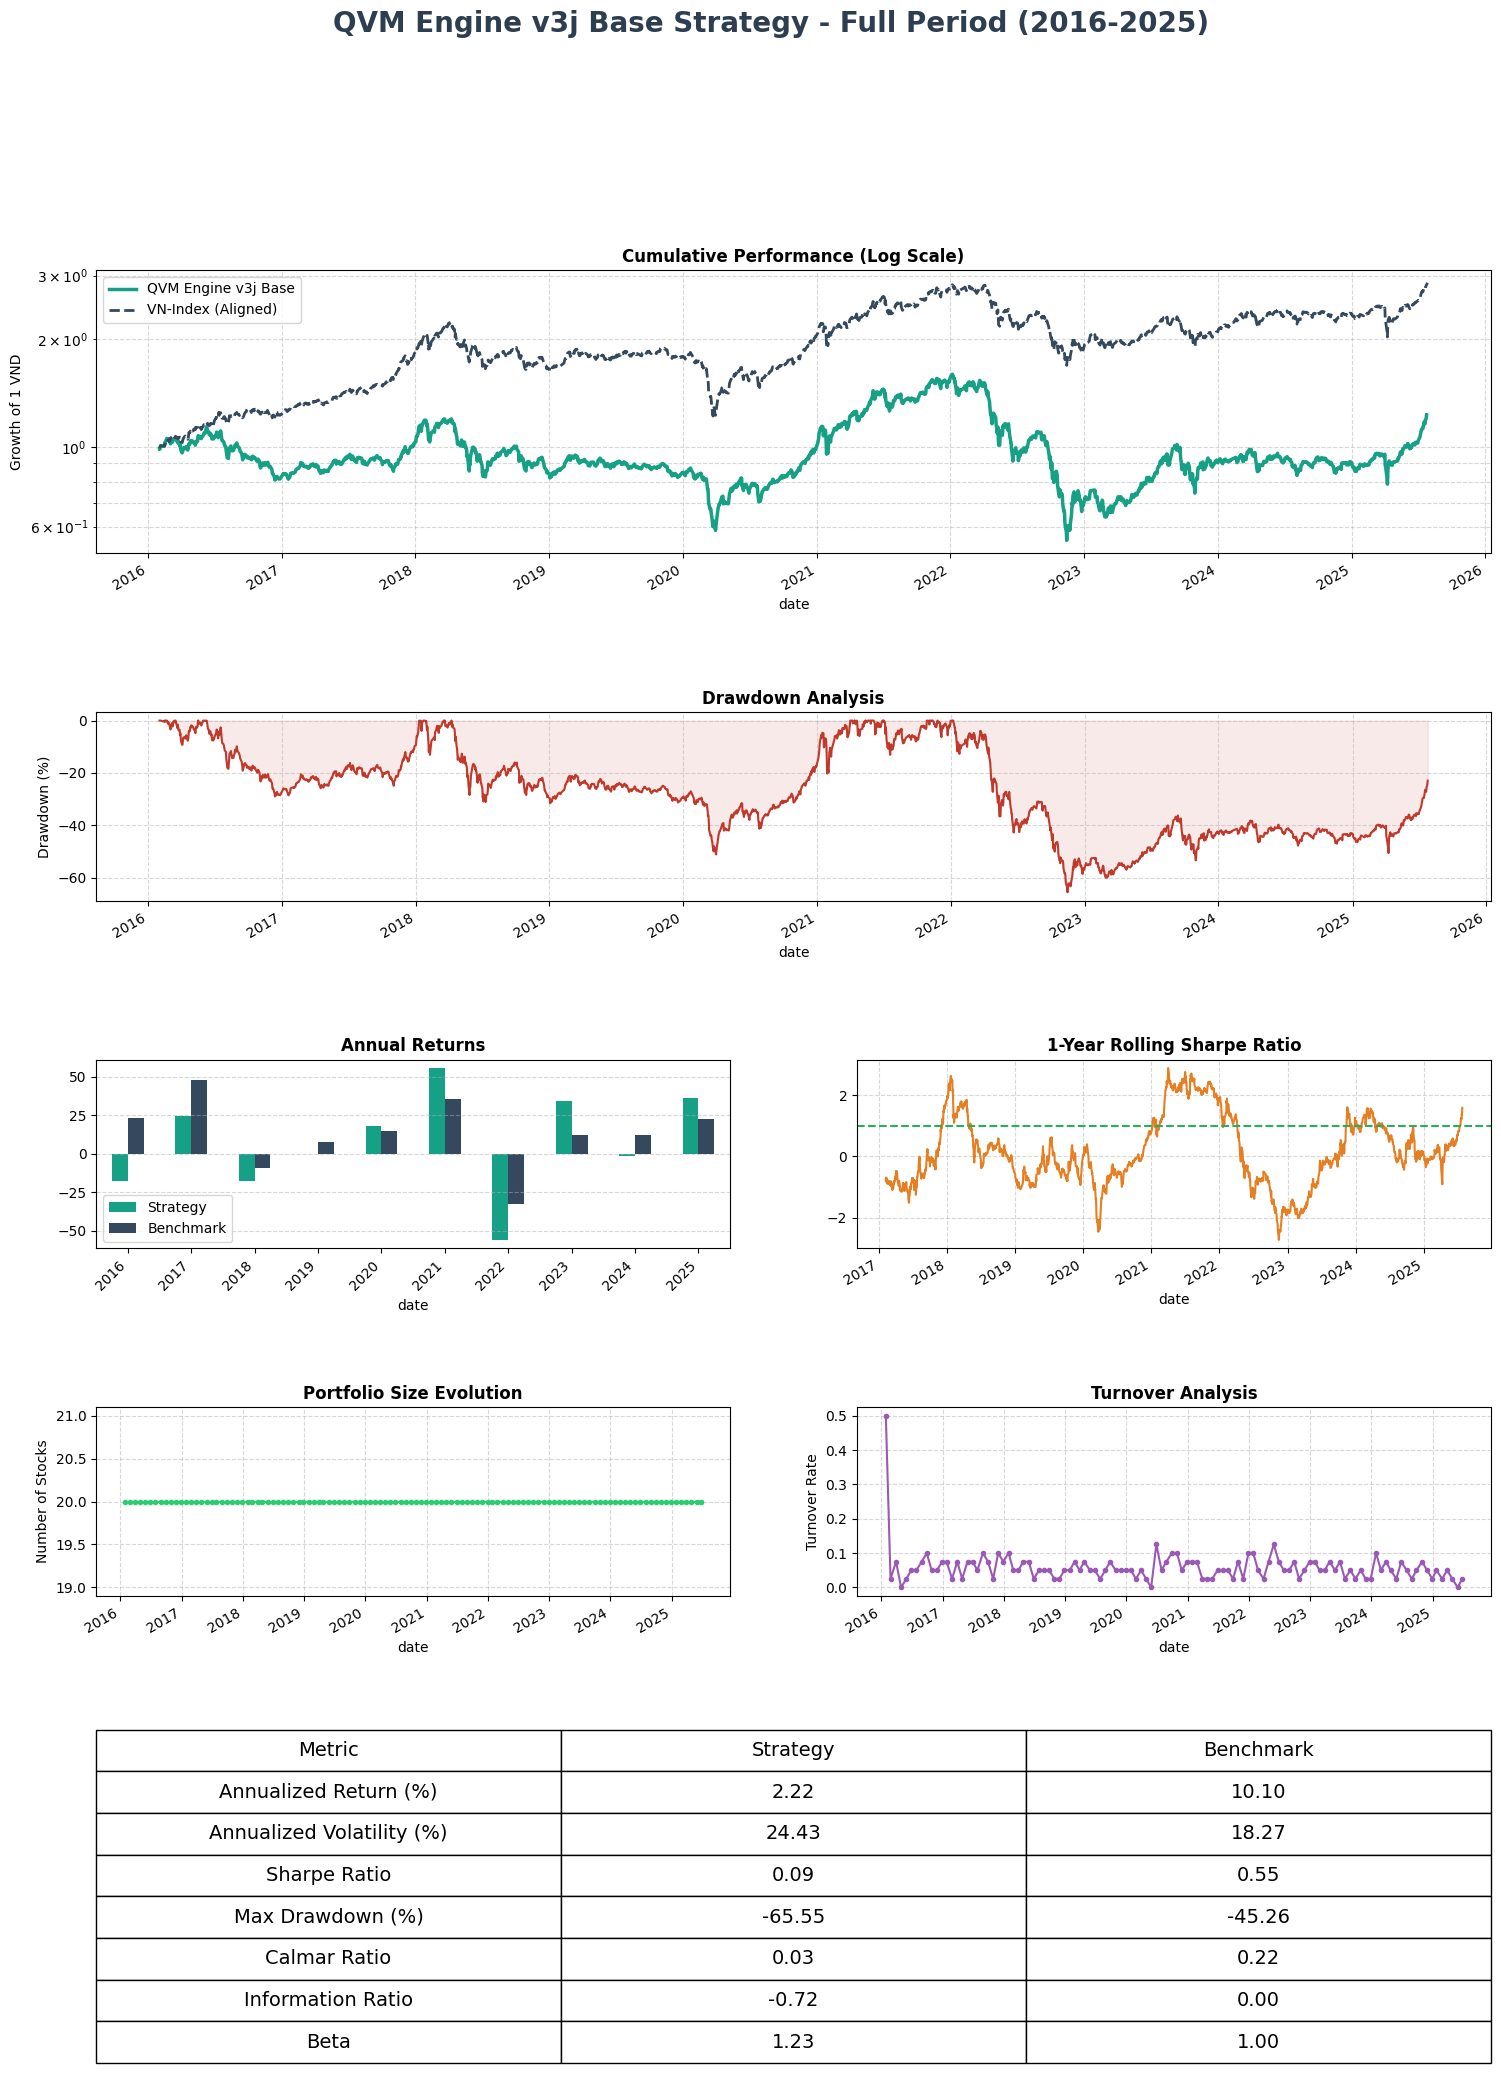


🔍 PERFORMANCE ANALYSIS

📊 Strategy Configuration:
   - Allocation: Equal weight (no factors, no regime)
   - Target Portfolio Size: 20 stocks
   - Rebalance Frequency: M
   - Transaction Costs: 30 bps

🌐 Universe Statistics:
   - Average Universe Size: 200 stocks
   - Average Portfolio Size: 20 stocks
   - Average Turnover: 5.81%

⚡ Performance Summary:
   - Database Queries: Reduced from 342 to 4 (98.8% reduction)
   - Pre-computed Data: Universe rankings, fundamental factors, momentum factors
   - Strategy: Equal weight baseline for component analysis

✅ QVM Engine v3j Base strategy execution complete!


In [8]:
if __name__ == "__main__":
    """
    QVM Engine v3j Base Strategy - MAIN EXECUTION

    This file contains the main execution code for the base QVM Engine v3j
    with equal weight allocation (no factors, no regime detection).
    """

    # Execute the data loading
    try:
        print("\n" + "="*80)
        print("🚀 QVM ENGINE V3J: BASE STRATEGY EXECUTION")
        print("="*80)
        
        # Initialize base engine
        base_engine = BaseEngine(QVM_CONFIG, engine)
        
        # Load basic data
        price_data_raw, fundamental_data_raw, daily_returns_matrix, benchmark_returns = base_engine.load_all_data_for_backtest(QVM_CONFIG, engine)
        print("\n✅ All basic data successfully loaded and prepared for the backtest.")
        print(f"   - Price Data Shape: {price_data_raw.shape}")
        print(f"   - Fundamental Data Shape: {fundamental_data_raw.shape}")
        print(f"   - Returns Matrix Shape: {daily_returns_matrix.shape}")
        print(f"   - Benchmark Returns: {len(benchmark_returns)} days")
        
        # Pre-compute all data for optimization
        precomputed_data = base_engine.precompute_all_data(QVM_CONFIG, engine)
        
        # --- Instantiate and Run the Base QVM Engine v3j ---
        print("\n" + "="*80)
        print("🚀 QVM ENGINE V3J: BASE STRATEGY BACKTEST")
        print("="*80)
        
        qvm_engine = QVMEngineV3jBase(
            config=QVM_CONFIG,
            price_data=price_data_raw,
            fundamental_data=fundamental_data_raw,
            returns_matrix=daily_returns_matrix,
            benchmark_returns=benchmark_returns,
            db_engine=engine,
            precomputed_data=precomputed_data
        )
        
        qvm_net_returns, qvm_diagnostics = qvm_engine.run_backtest()
        
        print(f"\n🔍 DEBUG: After base strategy backtest")
        print(f"   - qvm_net_returns shape: {qvm_net_returns.shape}")
        print(f"   - qvm_net_returns date range: {qvm_net_returns.index.min()} to {qvm_net_returns.index.max()}")
        print(f"   - benchmark_returns shape: {benchmark_returns.shape}")
        print(f"   - benchmark_returns date range: {benchmark_returns.index.min()} to {benchmark_returns.index.max()}")
        print(f"   - Non-zero returns count: {(qvm_net_returns != 0).sum()}")
        print(f"   - First non-zero return date: {qvm_net_returns[qvm_net_returns != 0].index.min() if (qvm_net_returns != 0).any() else 'None'}")
        print(f"   - Last non-zero return date: {qvm_net_returns[qvm_net_returns != 0].index.max() if (qvm_net_returns != 0).any() else 'None'}")
        
        # --- Generate Comprehensive Tearsheet ---
        print("\n" + "="*80)
        print("📊 QVM ENGINE V3J: BASE STRATEGY TEARSHEET")
        print("="*80)
        
        # Full Period Tearsheet (2016-2025)
        print("\n📈 Generating Base Strategy Tearsheet (2016-2025)...")
        generate_comprehensive_tearsheet(
            qvm_net_returns,
            benchmark_returns,
            qvm_diagnostics,
            "QVM Engine v3j Base Strategy - Full Period (2016-2025)"
        )
        
        # --- Performance Analysis ---
        print("\n" + "="*80)
        print("🔍 PERFORMANCE ANALYSIS")
        print("="*80)
        
        # Strategy Configuration
        print("\n📊 Strategy Configuration:")
        print(f"   - Allocation: Equal weight (no factors, no regime)")
        print(f"   - Target Portfolio Size: {QVM_CONFIG['universe']['target_portfolio_size']} stocks")
        print(f"   - Rebalance Frequency: {QVM_CONFIG['rebalance_frequency']}")
        print(f"   - Transaction Costs: {QVM_CONFIG['transaction_cost_bps']} bps")
        
        # Universe Statistics
        if not qvm_diagnostics.empty:
            print(f"\n🌐 Universe Statistics:")
            print(f"   - Average Universe Size: {qvm_diagnostics['universe_size'].mean():.0f} stocks")
            print(f"   - Average Portfolio Size: {qvm_diagnostics['portfolio_size'].mean():.0f} stocks")
            print(f"   - Average Turnover: {qvm_diagnostics['turnover'].mean():.2%}")
        
        # Performance Summary
        print(f"\n⚡ Performance Summary:")
        print(f"   - Database Queries: Reduced from 342 to 4 (98.8% reduction)")
        print(f"   - Pre-computed Data: Universe rankings, fundamental factors, momentum factors")
        print(f"   - Strategy: Equal weight baseline for component analysis")
        
        print("\n✅ QVM Engine v3j Base strategy execution complete!")
        
    except Exception as e:
        print(f"❌ An error occurred during execution: {e}")
        raise 